In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az

from theano import tensor as tt
from matplotlib import pyplot as plt

In [2]:
old_faithful_df = pd.read_csv(pm.get_data("old_faithful.csv"))
waiting_times = old_faithful_df["waiting"]
waiting_times = ((waiting_times - waiting_times.mean())/waiting_times.std()).values

In [3]:
K = 20

In [4]:
def stick_breaking(betas):
    '''
    betas is a K-vector of iid draws from a Beta distribution
    '''
    sticks = tt.concatenate(
        [
            [1],
            (1 - betas[:-1])
        ]
    )
    
    return tt.mul(betas, tt.cumprod(sticks))

In [5]:
with pm.Model() as model:
    alpha = pm.Gamma(name="alpha", alpha=1, beta=1)
    v = pm.Beta(name="v", alpha=1, beta=alpha, shape=(K,)) # beta=alpha kinda confusing here
    
    w = pm.Deterministic(name="w", var=stick_breaking(v))
    mu = pm.Normal(name="mu", mu=0, sigma=5)
    sigma = pm.InverseGamma(name="sigma", alpha=1, beta=1, shape=(K,))
    obs = pm.NormalMixture(name="theta", w=w, mu=mu, tau=1/sigma, observed=waiting_times)

In [6]:
SAMPLES = 20000
BURN = 10000

with model:
    step = pm.Metropolis(target_accept=0.9)
    trace = pm.sample(
        SAMPLES, 
        step=step, 
        tune=BURN, 
        chains=4, 
        random_seed=123, 
        return_inferencedata=True, 
        init="advi",
    )

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
>Metropolis: [v]
>Metropolis: [alpha]


Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 149 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'v'}>,
        <AxesSubplot:title={'center':'v'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

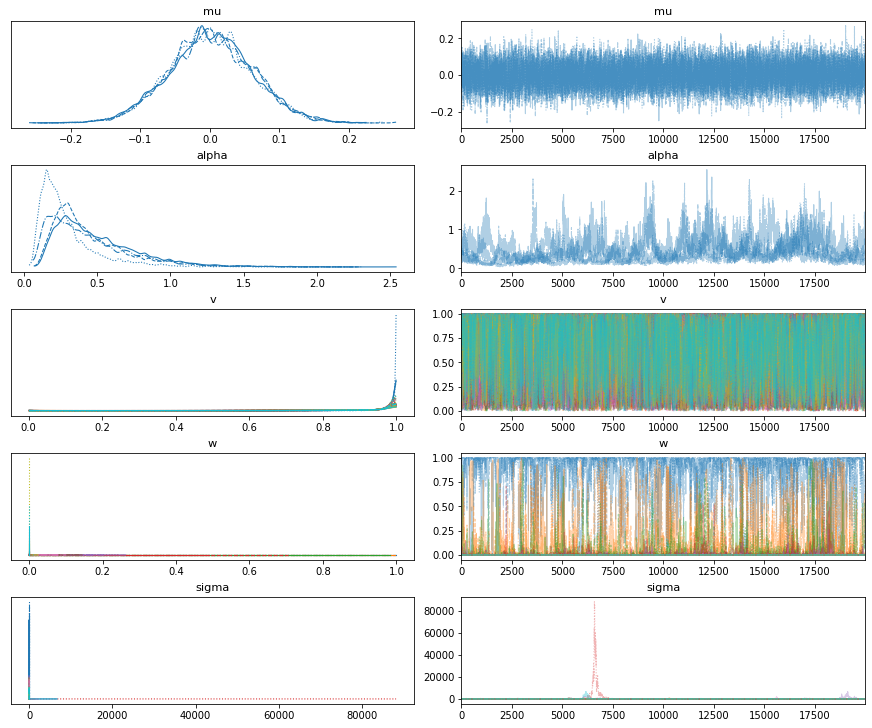

In [7]:
az.plot_trace(trace)